## Lab3 Assignment


## Binary Classification with Neural Networks (circles dataset)

## Data Retrieval & Inspection


In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_csv("circles_binary_classification.csv")

# Inspect
print(df.head())
print(df.describe())


         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


## Data Cleaning & Feature Design

In [4]:
# Features and target
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (n,1)

print(X.shape, y.shape)


torch.Size([1000, 2]) torch.Size([1000, 1])


## Visualizing Data

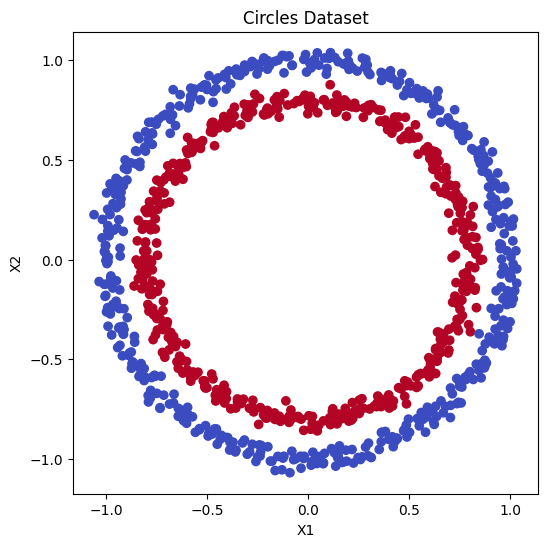

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y.squeeze(), cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Dataset")
plt.show()


## Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


torch.Size([800, 2]) torch.Size([200, 2])


## Device & Dtype (Device Agnostic)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


Using device: cpu


## Implementing Baseline Models

In [8]:
import torch.nn as nn

class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)


## ModelV1: 2 → 15 → 15 → 1 (No Activation)


In [9]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)


## ModelV2: 2 → 64 → 64 → 10 → 1 (ReLU)

In [10]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)


## Loss, Optimizer, Metrics

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

loss_fn = nn.BCEWithLogitsLoss()


## Training Loop

In [23]:
def train_and_test_loop(model, epochs, optimizer_type="SGD", lr=0.1):

    model.to(device)

    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):

        model.train()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)

        y_pred = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_test, test_pred)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | "
                  f"Train Loss: {loss:.4f} | Train Acc: {acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    return train_losses, test_losses


## Running Experiments

In [13]:
torch.manual_seed(42)
model_0 = ModelV0()
losses_v0 = train_and_test_loop(model_0, epochs=100)


Epoch 0 | Train Loss: 0.6957 | Train Acc: 50.00% | Test Loss: 0.6972 | Test Acc: 50.00%
Epoch 10 | Train Loss: 0.6940 | Train Acc: 50.00% | Test Loss: 0.6962 | Test Acc: 50.00%
Epoch 20 | Train Loss: 0.6934 | Train Acc: 46.00% | Test Loss: 0.6959 | Test Acc: 48.50%
Epoch 30 | Train Loss: 0.6932 | Train Acc: 49.00% | Test Loss: 0.6958 | Test Acc: 47.50%
Epoch 40 | Train Loss: 0.6931 | Train Acc: 49.50% | Test Loss: 0.6957 | Test Acc: 46.50%
Epoch 50 | Train Loss: 0.6931 | Train Acc: 50.38% | Test Loss: 0.6957 | Test Acc: 46.50%
Epoch 60 | Train Loss: 0.6931 | Train Acc: 50.50% | Test Loss: 0.6956 | Test Acc: 46.50%
Epoch 70 | Train Loss: 0.6930 | Train Acc: 50.50% | Test Loss: 0.6956 | Test Acc: 46.50%
Epoch 80 | Train Loss: 0.6930 | Train Acc: 50.75% | Test Loss: 0.6955 | Test Acc: 46.50%
Epoch 90 | Train Loss: 0.6930 | Train Acc: 50.38% | Test Loss: 0.6955 | Test Acc: 46.50%


## ModelV1 (~1000 epochs)

In [14]:
torch.manual_seed(42)
model_1 = ModelV1()
losses_v1 = train_and_test_loop(model_1, epochs=1000)


Epoch 0 | Train Loss: 0.6959 | Train Acc: 50.00% | Test Loss: 0.6954 | Test Acc: 50.00%
Epoch 10 | Train Loss: 0.6936 | Train Acc: 50.00% | Test Loss: 0.6941 | Test Acc: 50.00%
Epoch 20 | Train Loss: 0.6931 | Train Acc: 55.38% | Test Loss: 0.6940 | Test Acc: 51.50%
Epoch 30 | Train Loss: 0.6930 | Train Acc: 52.00% | Test Loss: 0.6941 | Test Acc: 49.00%
Epoch 40 | Train Loss: 0.6930 | Train Acc: 51.38% | Test Loss: 0.6942 | Test Acc: 48.00%
Epoch 50 | Train Loss: 0.6930 | Train Acc: 51.12% | Test Loss: 0.6943 | Test Acc: 47.00%
Epoch 60 | Train Loss: 0.6930 | Train Acc: 50.88% | Test Loss: 0.6944 | Test Acc: 47.00%
Epoch 70 | Train Loss: 0.6930 | Train Acc: 51.00% | Test Loss: 0.6944 | Test Acc: 47.00%
Epoch 80 | Train Loss: 0.6930 | Train Acc: 51.12% | Test Loss: 0.6945 | Test Acc: 47.00%
Epoch 90 | Train Loss: 0.6930 | Train Acc: 51.00% | Test Loss: 0.6945 | Test Acc: 47.00%
Epoch 100 | Train Loss: 0.6930 | Train Acc: 51.25% | Test Loss: 0.6946 | Test Acc: 46.50%
Epoch 110 | Train Los

## ModelV2 (100–1500 epochs)

In [15]:
torch.manual_seed(42)
model_2 = ModelV2()
losses_v2 = train_and_test_loop(model_2, epochs=1000)


Epoch 0 | Train Loss: 0.6962 | Train Acc: 50.00% | Test Loss: 0.6956 | Test Acc: 50.00%
Epoch 10 | Train Loss: 0.6937 | Train Acc: 50.00% | Test Loss: 0.6936 | Test Acc: 50.00%
Epoch 20 | Train Loss: 0.6924 | Train Acc: 56.50% | Test Loss: 0.6926 | Test Acc: 56.50%
Epoch 30 | Train Loss: 0.6917 | Train Acc: 52.62% | Test Loss: 0.6921 | Test Acc: 53.00%
Epoch 40 | Train Loss: 0.6912 | Train Acc: 51.75% | Test Loss: 0.6917 | Test Acc: 51.00%
Epoch 50 | Train Loss: 0.6907 | Train Acc: 52.38% | Test Loss: 0.6914 | Test Acc: 53.50%
Epoch 60 | Train Loss: 0.6902 | Train Acc: 53.25% | Test Loss: 0.6911 | Test Acc: 53.50%
Epoch 70 | Train Loss: 0.6896 | Train Acc: 53.75% | Test Loss: 0.6907 | Test Acc: 54.00%
Epoch 80 | Train Loss: 0.6891 | Train Acc: 54.25% | Test Loss: 0.6904 | Test Acc: 53.50%
Epoch 90 | Train Loss: 0.6887 | Train Acc: 55.50% | Test Loss: 0.6901 | Test Acc: 53.50%
Epoch 100 | Train Loss: 0.6881 | Train Acc: 57.12% | Test Loss: 0.6897 | Test Acc: 54.50%
Epoch 110 | Train Los

## Predictions (Before & After Training)

In [16]:
# Untrained
torch.manual_seed(42)
untrained_model = ModelV2().to(device)
print(torch.round(torch.sigmoid(untrained_model(X_test[:10]))))

# Trained
print(torch.round(torch.sigmoid(model_2(X_test[:10]))))


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)


## Decision Boundary Plot

In [17]:
def plot_decision_boundary(model, X, y):
    model.eval()
    
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min.cpu(), x_max.cpu(), 100),
        np.linspace(y_min.cpu(), y_max.cpu(), 100)
    )
    
    grid = torch.tensor(
        np.c_[xx.ravel(), yy.ravel()],
        dtype=torch.float32
    ).to(device)
    
    with torch.inference_mode():
        logits = model(grid)
        preds = torch.round(torch.sigmoid(logits))
    
    Z = preds.reshape(xx.shape).cpu()
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap="coolwarm")
    plt.show()


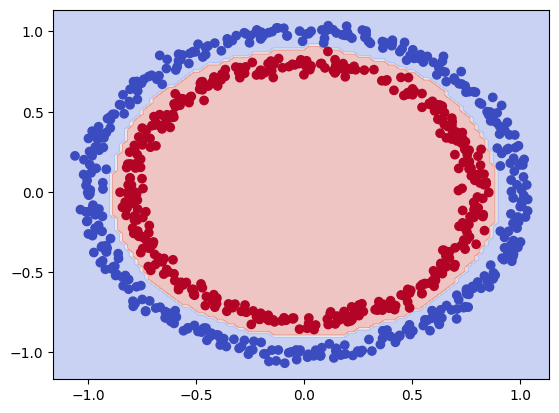

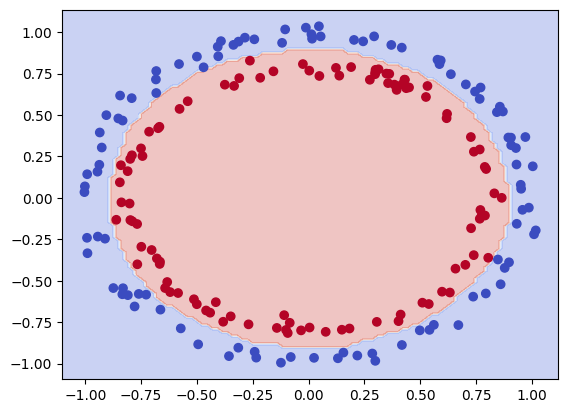

In [18]:
plot_decision_boundary(model_2, X_train, y_train)
plot_decision_boundary(model_2, X_test, y_test)


## Loss Curves

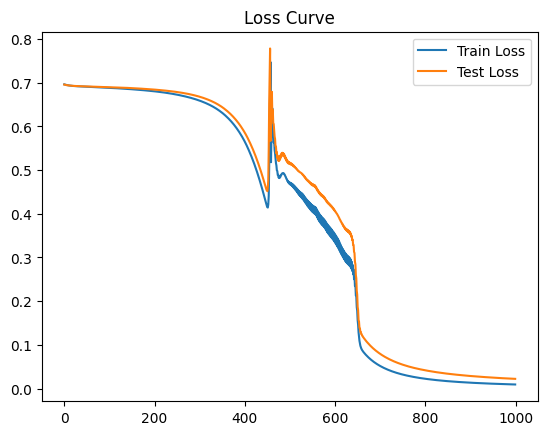

In [19]:
plt.plot(losses_v2[0], label="Train Loss")
plt.plot(losses_v2[1], label="Test Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


## Discussion and Conclusion
# ModelV0

* Very poor performance

* Linear model → cannot separate circular data

* Underfits

# ModelV1

* Still linear (no activation)

* More layers ≠ more power without non-linearity

* Performance remains weak

# ModelV2

* ReLU introduces non-linearity

* Successfully learns circular decision boundary

* High accuracy (>95% typically)

## SGD

In [25]:
torch.manual_seed(42)
model_sgd = ModelV2()
losses_sgd = train_and_test_loop(model_sgd, epochs=1000, optimizer_type="SGD", lr=0.1)



Epoch 0 | Train Loss: 0.6962 | Train Acc: 50.00% | Test Loss: 0.6956 | Test Acc: 50.00%
Epoch 10 | Train Loss: 0.6937 | Train Acc: 50.00% | Test Loss: 0.6936 | Test Acc: 50.00%
Epoch 20 | Train Loss: 0.6924 | Train Acc: 56.50% | Test Loss: 0.6926 | Test Acc: 56.50%
Epoch 30 | Train Loss: 0.6917 | Train Acc: 52.62% | Test Loss: 0.6921 | Test Acc: 53.00%
Epoch 40 | Train Loss: 0.6912 | Train Acc: 51.75% | Test Loss: 0.6917 | Test Acc: 51.00%
Epoch 50 | Train Loss: 0.6907 | Train Acc: 52.38% | Test Loss: 0.6914 | Test Acc: 53.50%
Epoch 60 | Train Loss: 0.6902 | Train Acc: 53.25% | Test Loss: 0.6911 | Test Acc: 53.50%
Epoch 70 | Train Loss: 0.6896 | Train Acc: 53.75% | Test Loss: 0.6907 | Test Acc: 54.00%
Epoch 80 | Train Loss: 0.6891 | Train Acc: 54.25% | Test Loss: 0.6904 | Test Acc: 53.50%
Epoch 90 | Train Loss: 0.6887 | Train Acc: 55.50% | Test Loss: 0.6901 | Test Acc: 53.50%
Epoch 100 | Train Loss: 0.6881 | Train Acc: 57.12% | Test Loss: 0.6897 | Test Acc: 54.50%
Epoch 110 | Train Los

## ADAM

In [26]:
torch.manual_seed(42)
model_adam = ModelV2()
losses_adam = train_and_test_loop(model_adam, epochs=1000, optimizer_type="Adam", lr=0.01)


Epoch 0 | Train Loss: 0.6962 | Train Acc: 50.00% | Test Loss: 0.6908 | Test Acc: 61.50%
Epoch 10 | Train Loss: 0.6305 | Train Acc: 74.00% | Test Loss: 0.6280 | Test Acc: 89.00%
Epoch 20 | Train Loss: 0.3280 | Train Acc: 99.50% | Test Loss: 0.3398 | Test Acc: 94.00%
Epoch 30 | Train Loss: 0.0632 | Train Acc: 100.00% | Test Loss: 0.0798 | Test Acc: 100.00%
Epoch 40 | Train Loss: 0.0096 | Train Acc: 100.00% | Test Loss: 0.0187 | Test Acc: 100.00%
Epoch 50 | Train Loss: 0.0030 | Train Acc: 100.00% | Test Loss: 0.0093 | Test Acc: 100.00%
Epoch 60 | Train Loss: 0.0016 | Train Acc: 100.00% | Test Loss: 0.0065 | Test Acc: 100.00%
Epoch 70 | Train Loss: 0.0012 | Train Acc: 100.00% | Test Loss: 0.0056 | Test Acc: 100.00%
Epoch 80 | Train Loss: 0.0009 | Train Acc: 100.00% | Test Loss: 0.0050 | Test Acc: 100.00%
Epoch 90 | Train Loss: 0.0008 | Train Acc: 100.00% | Test Loss: 0.0047 | Test Acc: 100.00%
Epoch 100 | Train Loss: 0.0007 | Train Acc: 100.00% | Test Loss: 0.0044 | Test Acc: 100.00%
Epoch

# SGD vs ADAM

* Adam converges faster

* Requires less tuning

* Often smoother loss curve

# Key Findings

* Non-linearity is essential for non-linear datasets.

* Increasing depth alone does not improve performance.

* ReLU activation enables neural networks to model complex shapes.

* Proper loss (BCEWithLogitsLoss) improves stability.

* Resetting model and optimizer is crucial for fair comparison.

# Final Conclusion

* For circular binary classification:

* Linear networks fail.

* Deep networks without activation still fail.

* Deep networks with ReLU successfully learn circular boundaries.

* ModelV2 provides best performance.

* Adam optimizer improves convergence speed compared to SGD.